In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Reading data and first glance at the data profile

In [2]:
df = pd.read_csv(r'data/campaigns.csv', index_col=0)

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


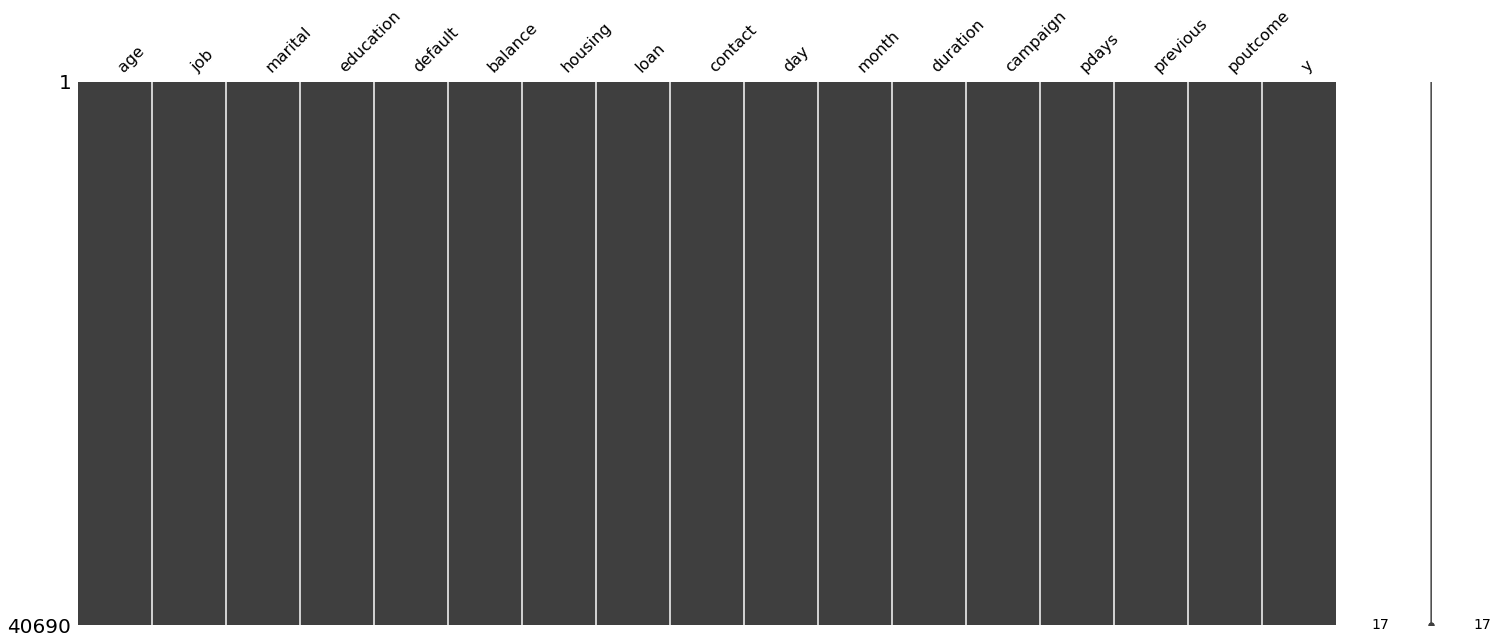

In [4]:
msno.matrix(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40690 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40690 non-null  int64 
 1   job        40690 non-null  object
 2   marital    40690 non-null  object
 3   education  40690 non-null  object
 4   default    40690 non-null  object
 5   balance    40690 non-null  int64 
 6   housing    40690 non-null  object
 7   loan       40690 non-null  object
 8   contact    40690 non-null  object
 9   day        40690 non-null  int64 
 10  month      40690 non-null  object
 11  duration   40690 non-null  int64 
 12  campaign   40690 non-null  int64 
 13  pdays      40690 non-null  int64 
 14  previous   40690 non-null  int64 
 15  poutcome   40690 non-null  object
 16  y          40690 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.6+ MB


## Target variable

In [6]:
df['y'].value_counts()

no     35903
yes     4787
Name: y, dtype: int64

**note:** The first thing to keep in mind is that this will be an imbalanced problem, that will most likely require re-sampling methods

## Numerical variables

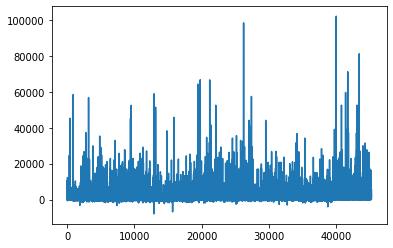

In [7]:
df['balance'].plot()

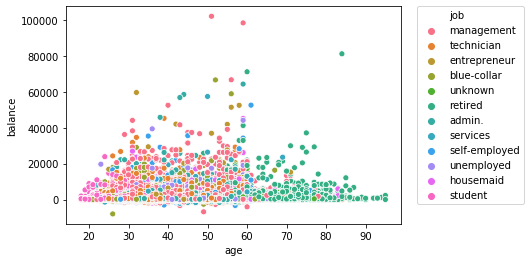

In [8]:
sns.scatterplot(data=df, x='age', y='balance', hue='job')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

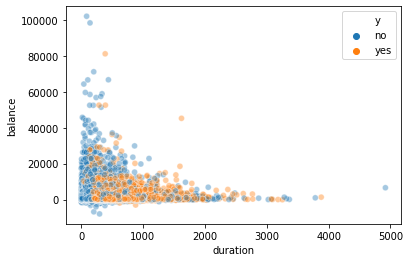

In [9]:
sns.scatterplot(data=df, x='duration', y='balance', hue='y', alpha=0.4)

**note:** if the contact duration is longer, it has a higher chance that the customer will make a deal, regardless of their balance. so a possible action would be to prepare an *empathic* approach to make a conversation more interesting (in a customer centric fashion - i.e.: understand the reasons why the customer needs our product first)

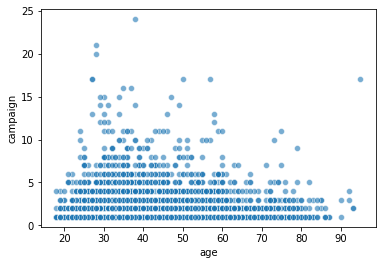

In [10]:
sns.scatterplot(data=df[df['y']=='yes'], x='age', y='campaign', alpha=0.6)

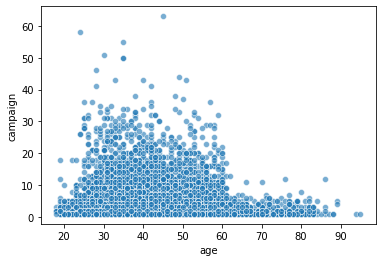

In [11]:
sns.scatterplot(data=df[df['y']=='no'], x='age', y='campaign', alpha=0.6)

**note:** these plots indicate that for all ages it is important to keep a smaller amount of contacts during each campaign

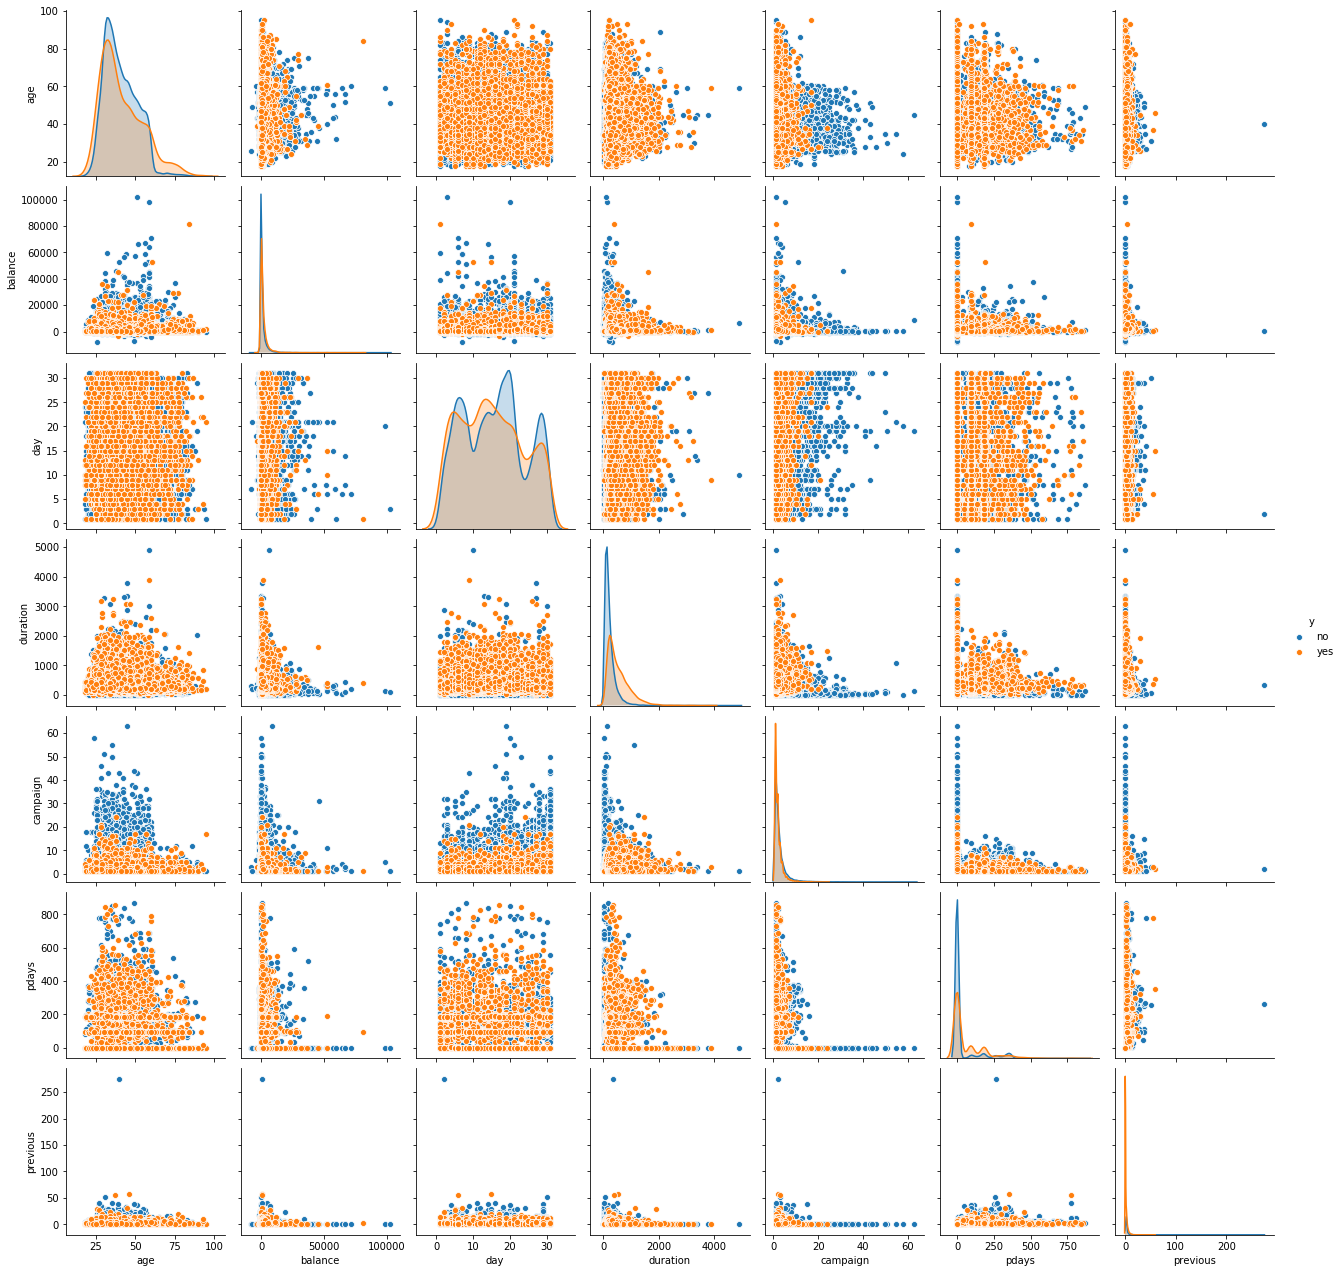

In [12]:
sns.pairplot(data=df, hue='y')

### Correlation matrix plot

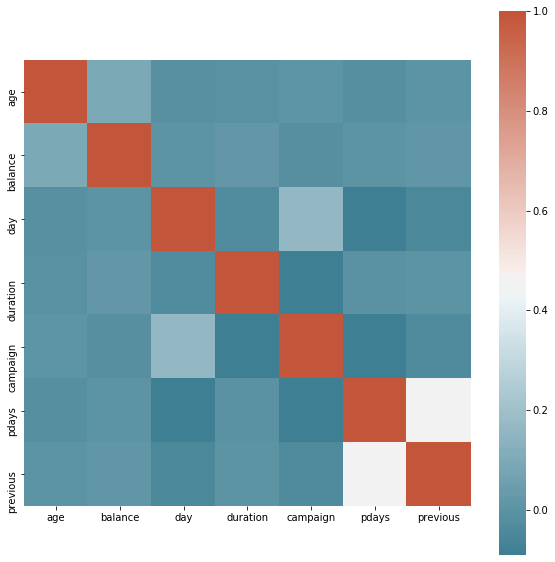

In [35]:
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, square=True, cmap=sns.diverging_palette(220,20, n=300))

**note:** the only noticeable correlation shows up between pdays and previous

## Categorical variables

In [41]:
cat_vars = []
for col in df.columns:
    if df[col].dtypes == np.object:
        cat_vars.append(col)

In [43]:
df[cat_vars].head(2)

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no


In [44]:
df['job'].value_counts()

blue-collar      8769
management       8504
technician       6818
admin.           4661
services         3725
retired          2027
self-employed    1427
entrepreneur     1339
unemployed       1193
housemaid        1125
student           848
unknown           254
Name: job, dtype: int64

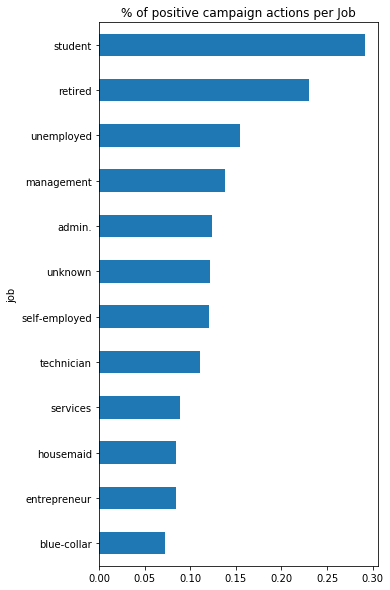

In [104]:
plt.figure(figsize=(5,10))
plt.title('% of positive campaign actions per Job')
(df[df['y']=='yes'].groupby(by='job').size() / df.groupby(by='job').size()).sort_values(ascending=True).plot.barh();

**note:** proportionally, the campaign seems to be working best amongst students, retired and unemployed people. the best segment of regular jobs are the management ones.

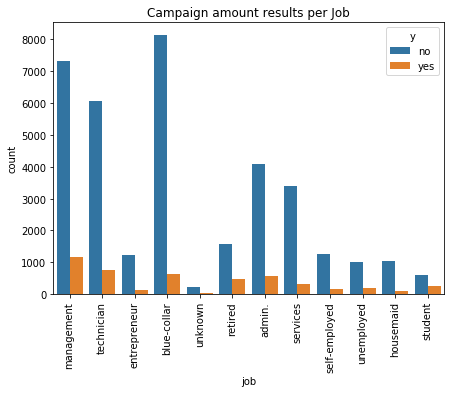

In [105]:
plt.figure(figsize=(7,5))
plt.title('Campaign amount results per Job')
sns.countplot(data=df, x='job', hue='y')
plt.xticks(rotation=90);

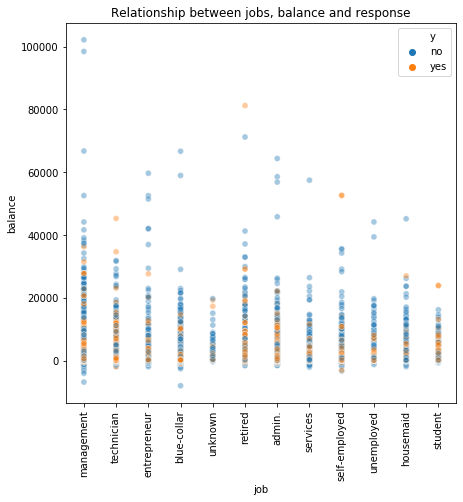

In [108]:
plt.figure(figsize=(7, 7))
plt.title('Relationship between jobs, balance and response')
sns.scatterplot(x='job', y='balance', data=df, hue='y', alpha=0.4)
plt.xticks(rotation=90);

In [70]:
df['marital'].value_counts()

married     24464
single      11531
divorced     4695
Name: marital, dtype: int64

In [78]:
df[df['y']=='yes']['marital'].value_counts(1)

married     0.518488
single      0.362231
divorced    0.119281
Name: marital, dtype: float64

**note:** it seems that married people are the most prone to react to our mkt campaing, but it is worth it to investigate it proportionally among each category

In [81]:
df[df['marital']=='married']['y'].value_counts(1)

no     0.898545
yes    0.101455
Name: y, dtype: float64

In [82]:
df[df['marital']=='single']['y'].value_counts(1)

no     0.849623
yes    0.150377
Name: y, dtype: float64

In [83]:
df[df['marital']=='divorced']['y'].value_counts(1)

no     0.878381
yes    0.121619
Name: y, dtype: float64

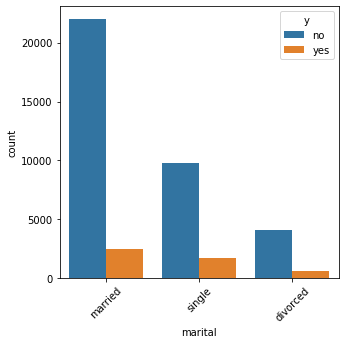

In [109]:
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='marital', hue='y')
plt.xticks(rotation=45);

**note:** the plot and the numbers really show that married people are in fact (not by much) the worst investment in the campaign

In [112]:
df['education'].value_counts()

secondary    20951
tertiary     11917
primary       6153
unknown       1669
Name: education, dtype: int64

In [142]:
df[df['y']=='yes']['education'].value_counts(1)

secondary    0.466681
tertiary     0.374765
primary      0.110090
unknown      0.048465
Name: education, dtype: float64

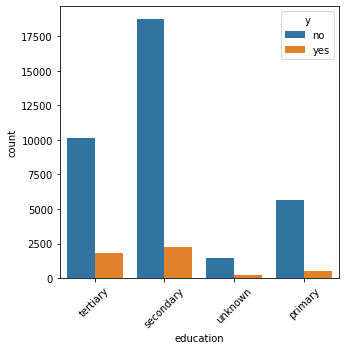

In [141]:
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='education', hue='y')
plt.xticks(rotation=45);

**note:** although the highest number of positive actions was placed on the 'secondary' category, it seems that the higher education tends to influence on how positive the campaign is going to be. might indicate this variable can be encoded ordinally

In [149]:
df['default'].value_counts(1)

no     0.982182
yes    0.017818
Name: default, dtype: float64

In [147]:
df[df['y']=='yes']['default'].value_counts(1)

no     0.990182
yes    0.009818
Name: default, dtype: float64

In [150]:
df[df['y']=='no']['default'].value_counts(1)

no     0.981116
yes    0.018884
Name: default, dtype: float64

**note:** there is a slight increase in how less often the customer has credit default if they react positively to the campaign

In [153]:
df['housing'].value_counts(1)

yes    0.556918
no     0.443082
Name: housing, dtype: float64

In [154]:
df[df['y']=='yes']['housing'].value_counts(1)

no     0.635262
yes    0.364738
Name: housing, dtype: float64

In [155]:
df[df['y']=='no']['housing'].value_counts(1)

yes    0.582542
no     0.417458
Name: housing, dtype: float64

**note:** there is a higher probability the customer will subscribe in case they don't have a housing loan

In [156]:
df[df['y']=='yes']['loan'].value_counts(1)

no     0.907458
yes    0.092542
Name: loan, dtype: float64

In [157]:
df[df['y']=='no']['loan'].value_counts(1)

no     0.830933
yes    0.169067
Name: loan, dtype: float64

**note:** the same as the previous two will happen for the personal loan

In [160]:
df['contact'].value_counts()

cellular     26319
unknown      11771
telephone     2600
Name: contact, dtype: int64

In [161]:
df[df['y']=='yes']['contact'].value_counts(1)

cellular     0.826405
unknown      0.098809
telephone    0.074786
Name: contact, dtype: float64

In [162]:
df[df['y']=='no']['contact'].value_counts(1)

cellular     0.622873
unknown      0.314681
telephone    0.062446
Name: contact, dtype: float64

**note:** the more is known about the communication channel, higher the chance the campaign will be successful

In [164]:
df['poutcome'].value_counts(1)

unknown    0.817990
failure    0.107569
other      0.040501
success    0.033940
Name: poutcome, dtype: float64

In [165]:
df[df['y']=='yes']['poutcome'].value_counts(1)

unknown    0.637560
success    0.186756
failure    0.116566
other      0.059118
Name: poutcome, dtype: float64

**note:** it is also best to know how the previous marketing campaign worked out for the customer to determine if this one will be successful

### Correlation - Cramer's V

To identify the categorical variables association, we will use the Cramer's V modified calculation, inspired by [this article](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

In [117]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [137]:
corr_cat = np.zeros(shape=(len(cat_vars),len(cat_vars)))
for i,vari in enumerate(cat_vars):
    for j,varj in enumerate(cat_vars):
        corr_cat[i][j]=(cramers_v(df[vari],df[varj]))
corr_cat_df = pd.DataFrame(corr_cat, columns=cat_vars, index=cat_vars)

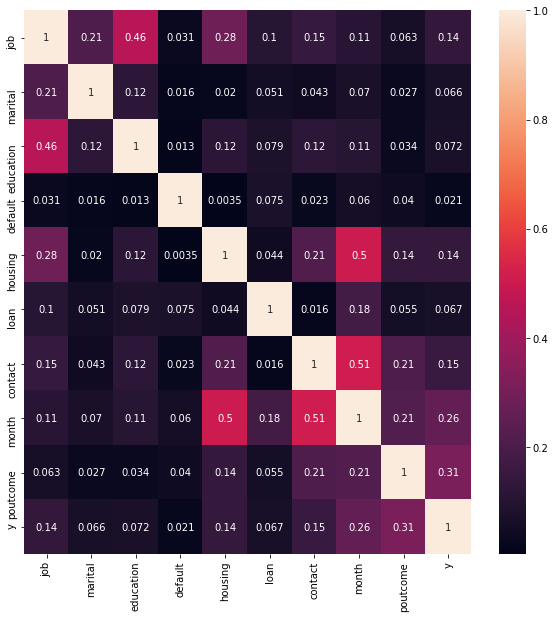

In [168]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_cat_df, annot=True)
plt.xticks(rotation=90);

**note:** some correlation is noticed between housing loan and job, which makes sense. the correlations between month and housing and contact might indicate some kind of seasonality, still ought to be checked.

## Feature Engineering

In [171]:
# Date variable
# Any Loan = housing * loan
# Any pendencies = housing * loan * default
# Ordinal encoding -> education, month
# poutcome_successful
# Dummy encoding

In [170]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


## Models experimentation

[x] Random Forest

[ ] LightGBM

[ ] XGBoost

### Random Forest

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [16]:
df_dummy = pd.get_dummies(df, drop_first=True)

In [17]:
df_dummy.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,y_yes
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [18]:
X = df_dummy.drop('y_yes', axis=1)
y= df_dummy['y_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)

In [20]:
cross_val_score(clf, X_train, y_train, cv=5)

array([0.89327716, 0.89678778, 0.89450588, 0.89518961, 0.8929073 ])

In [21]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [22]:
from sklearn.metrics import classification_report
target_names = ['yes', 'no']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         yes       0.89      1.00      0.94     10716
          no       0.79      0.11      0.20      1491

    accuracy                           0.89     12207
   macro avg       0.84      0.55      0.57     12207
weighted avg       0.88      0.89      0.85     12207



## Over sampling - ADASYN

In [23]:
from imblearn.over_sampling import ADASYN

In [24]:
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X, y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
target_names = ['yes', 'no']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         yes       0.91      0.86      0.88     10826
          no       0.87      0.92      0.89     11095

    accuracy                           0.89     21921
   macro avg       0.89      0.89      0.89     21921
weighted avg       0.89      0.89      0.89     21921



## Explaining feature importances

In [28]:
# Random Forest feature importances
# Random Forest node plot
clf.feature_importances_

array([2.37204554e-03, 9.50094734e-04, 4.39655791e-03, 2.12499994e-01,
       1.27026489e-02, 2.10379757e-02, 7.33353566e-03, 4.60838579e-02,
       2.86235698e-03, 1.34598753e-03, 1.44069034e-02, 2.04684930e-04,
       1.35198461e-03, 7.91302540e-03, 9.29577506e-06, 1.37189090e-02,
       3.99875556e-04, 2.43398967e-05, 6.61205011e-02, 1.51638180e-02,
       5.05828993e-02, 1.08482822e-02, 1.73572066e-03, 1.25414487e-05,
       1.50952531e-01, 3.85924003e-02, 2.37737999e-03, 1.12748472e-01,
       2.56847147e-02, 4.57316641e-07, 2.14230500e-03, 1.16402324e-03,
       3.76729211e-02, 1.84648301e-02, 4.49746278e-05, 8.44032635e-02,
       1.10594802e-02, 2.59813526e-04, 4.52131906e-05, 3.51406991e-03,
       7.04699611e-03, 9.74831829e-03])

In [ ]:
# SHAPley